# Model Metrics Visualization

This notebook visualizes precision, recall, and F1 scores for labels 0-5 from saved model metrics.

In [29]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

sys.path.append(str(Path.cwd().parent.parent))
from utils import DATA_DIR

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 5)

metrics_files = list((DATA_DIR / "metrics" / "encoder").glob("*.json"))
metrics_files = [f for f in metrics_files if not f.name.startswith("finetuned")]

MODEL_ORDER = ["random", "ridge", "rf", "svm", "catboost"]
EMBED_ORDER = ["minilm", "mbert"]

metrics_files.sort(
    key=lambda f: MODEL_ORDER.index(f.stem.split("_")[0])
    if f.stem.split("_")[0] in MODEL_ORDER
    else len(MODEL_ORDER)
)
metrics_files.sort(
    key=lambda f: EMBED_ORDER.index(f.stem.split("_")[1])
    if f.stem.split("_")[1] in EMBED_ORDER
    else -1
)

print("Available metrics files:")
for i, f in enumerate(metrics_files):
    print(f"  - [{i}] {f.name}")

Available metrics files:
  - [0] random_20251121_152716.json
  - [1] ridge_minilm_20251121_143817.json
  - [2] rf_minilm_20251121_143823.json
  - [3] svm_minilm_20251121_143819.json
  - [4] catboost_minilm_20251121_143829.json
  - [5] ridge_mbert_20251121_152717.json
  - [6] rf_mbert_20251121_152723.json
  - [7] svm_mbert_20251121_152718.json
  - [8] catboost_mbert_20251121_152731.json


## Specific model

In [13]:
# Select a metric file to visualize
METRICS_FILE = metrics_files[1]
with open(METRICS_FILE, "r") as f:
    metrics_data = json.load(f)


def extract_per_label_metrics(metrics_dict, dataset="test_metrics"):
    """
    Extract precision, recall, and F1 scores for labels 0-5.

    Args:
        metrics_dict: Dictionary containing model metrics
        dataset: Which dataset to use ('train_metrics', 'cv_metrics', or 'test_metrics')

    Returns:
        DataFrame with precision, recall, and F1 scores for each label
    """
    if metrics_dict[dataset] is None:
        print(f"Warning: {dataset} not available for this model")
        return None

    data = metrics_dict[dataset]

    # Pad with 0.0 if label 5 is missing
    precision = data["precision"] + [0.0] * (6 - len(data["precision"]))
    recall = data["recall"] + [0.0] * (6 - len(data["recall"]))
    f1 = data["f1"] + [0.0] * (6 - len(data["f1"]))
    support = data["support"] + [0] * (6 - len(data["support"]))

    df = pd.DataFrame(
        {
            "Label": range(6),
            "Precision": precision[:6],
            "Recall": recall[:6],
            "F1": f1[:6],
            "Support": support[:6],
        }
    )

    return df


train_df = extract_per_label_metrics(metrics_data, "train_metrics")
cv_df = extract_per_label_metrics(metrics_data, "cv_metrics")
test_df = extract_per_label_metrics(metrics_data, "test_metrics")

print(f"Model: {metrics_data['model']}")
print(f"Parameters: {metrics_data['params']}")

Model: ridge_minilm
Parameters: {'ridge_alpha': 0.01}


### Tables

In [14]:
print("=" * 60)
print("TRAIN METRICS")
print("=" * 60)


def _styled_no_index(df):
    """
    Return a Styler that formats columns and hides the row index by CSS.
    This avoids using Styler.hide_index() which may not be available in older pandas.
    """
    fmt = {"Precision": "{:.4f}", "Recall": "{:.4f}", "F1": "{:.4f}", "Support": "{:d}"}
    # Hide the index column via CSS selectors for row headings / blank header
    return df.style.format(fmt).set_table_styles(
        [{"selector": "th.row_heading, th.blank", "props": [("display", "none")]}]
    )


if train_df is not None:
    display(_styled_no_index(train_df))
    if metrics_data.get("train_metrics") is not None:
        print(f"Accuracy: {metrics_data['train_metrics']['accuracy']:.4f}")
        print(f"MSE: {metrics_data['train_metrics']['mse']:.4f}")

print("\n" + "=" * 60)
print("CROSS-VALIDATION METRICS")
print("=" * 60)
if cv_df is not None:
    display(_styled_no_index(cv_df))
    if metrics_data.get("cv_metrics") is not None:
        print(f"Accuracy: {metrics_data['cv_metrics']['accuracy']:.4f}")
        print(f"MSE: {metrics_data['cv_metrics']['mse']:.4f}")

print("\n" + "=" * 60)
print("TEST METRICS")
print("=" * 60)
if test_df is not None:
    display(_styled_no_index(test_df))
    if metrics_data.get("test_metrics") is not None:
        print(f"Accuracy: {metrics_data['test_metrics']['accuracy']:.4f}")
        print(f"MSE: {metrics_data['test_metrics']['mse']:.4f}")

TRAIN METRICS


,Label,Precision,Recall,F1,Support
0,0,1.0000,1.0000,1.0000,73
1,1,1.0000,1.0000,1.0000,42
2,2,1.0000,1.0000,1.0000,68
3,3,1.0000,1.0000,1.0000,79
4,4,1.0000,1.0000,1.0000,65
5,5,1.0000,1.0000,1.0000,65


Accuracy: 1.0000
MSE: 0.0000

CROSS-VALIDATION METRICS


,Label,Precision,Recall,F1,Support
0,0,0.6600,0.1789,0.2784,73
1,1,0.1973,0.3889,0.2525,42
2,2,0.2428,0.3675,0.2802,68
3,3,0.4226,0.3816,0.3945,79
4,4,0.4363,0.4198,0.4216,65
5,5,0.8115,0.6837,0.7271,65


Accuracy: 0.3927
MSE: 1.1561

TEST METRICS


,Label,Precision,Recall,F1,Support
0,0,0.7143,0.2041,0.3175,49
1,1,0.2692,0.5000,0.3500,28
2,2,0.3043,0.4667,0.3684,45
3,3,0.3913,0.3462,0.3673,52
4,4,0.5789,0.5000,0.5366,44
5,5,0.8140,0.7955,0.8046,44


Accuracy: 0.4580
MSE: 0.9924


### Confusion Matrix

TRAIN SET CONFUSION MATRIX


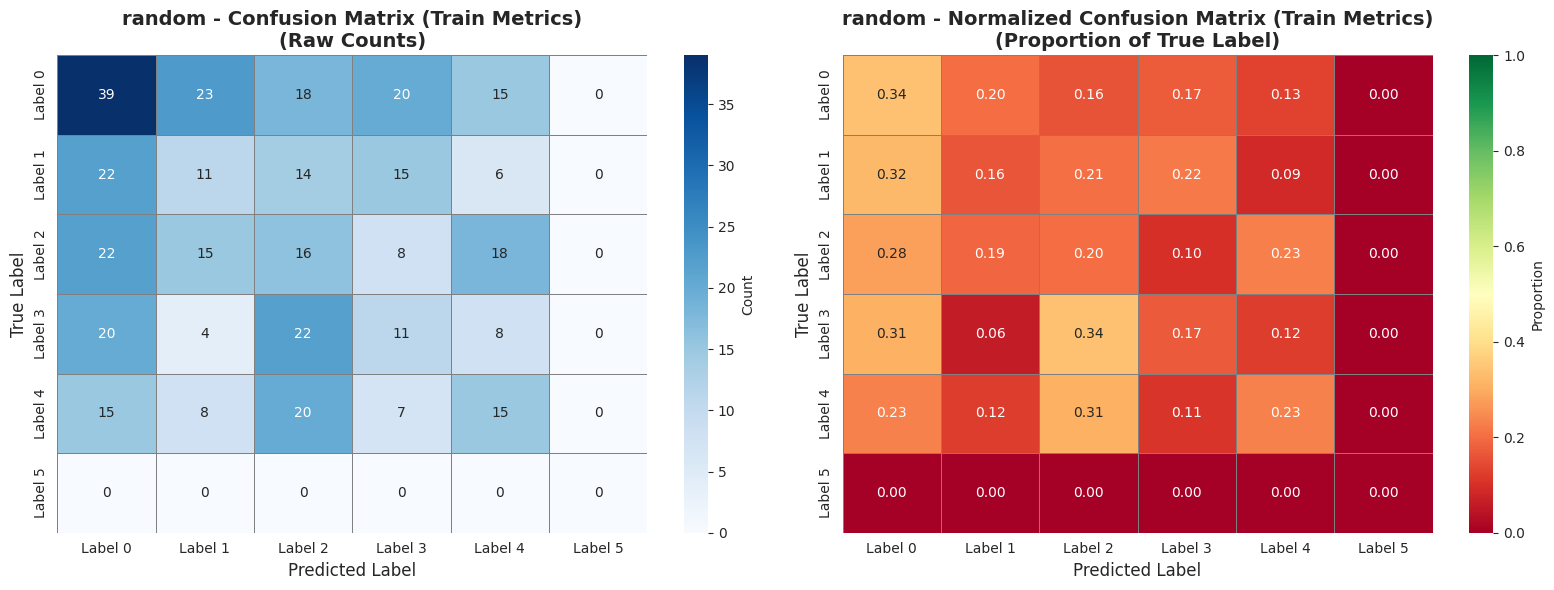


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 92
  Incorrect predictions (off-diagonal): 300
  Accuracy: 0.2347

Per-label statistics:
  Label 0: 39/115 correct (33.91%)
  Label 1: 11/68 correct (16.18%)
  Label 2: 16/79 correct (20.25%)
  Label 3: 11/65 correct (16.92%)
  Label 4: 15/65 correct (23.08%)
  Label 5: No samples

CROSS-VALIDATION CONFUSION MATRIX


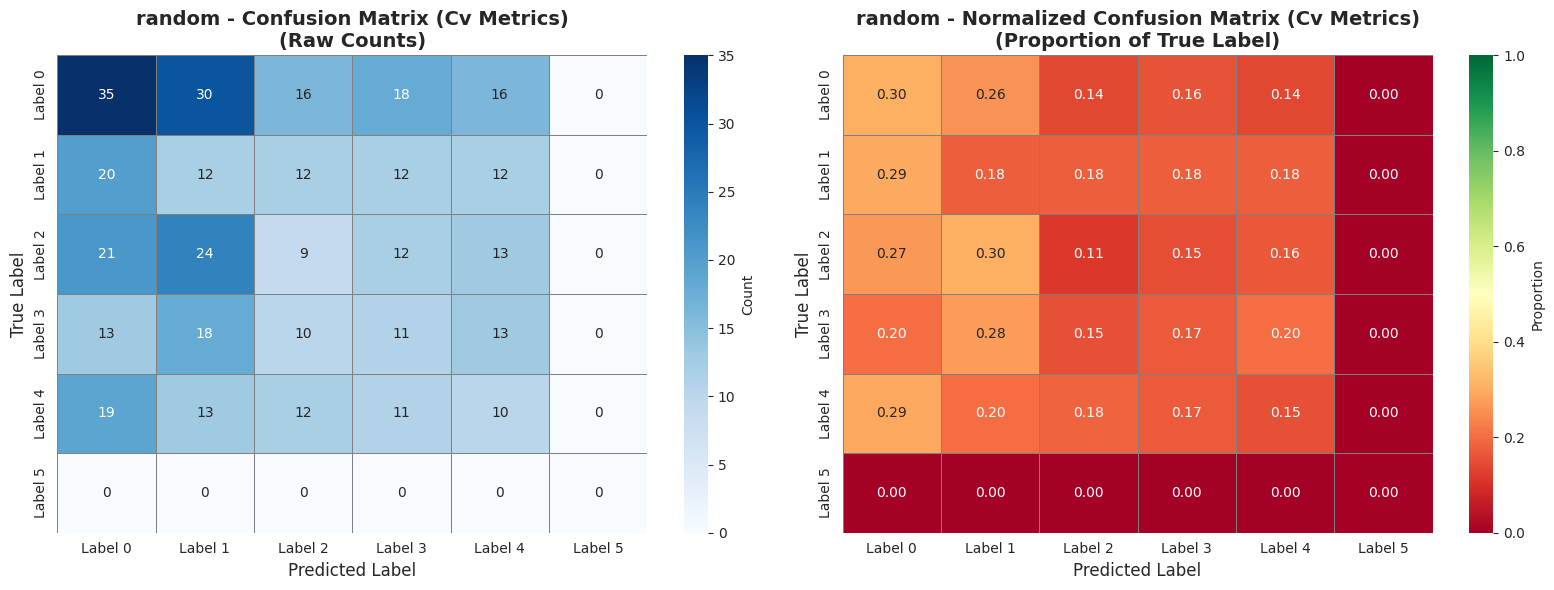


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 77
  Incorrect predictions (off-diagonal): 315
  Accuracy: 0.1964

Per-label statistics:
  Label 0: 35/115 correct (30.43%)
  Label 1: 12/68 correct (17.65%)
  Label 2: 9/79 correct (11.39%)
  Label 3: 11/65 correct (16.92%)
  Label 4: 10/65 correct (15.38%)
  Label 5: No samples

TEST SET CONFUSION MATRIX


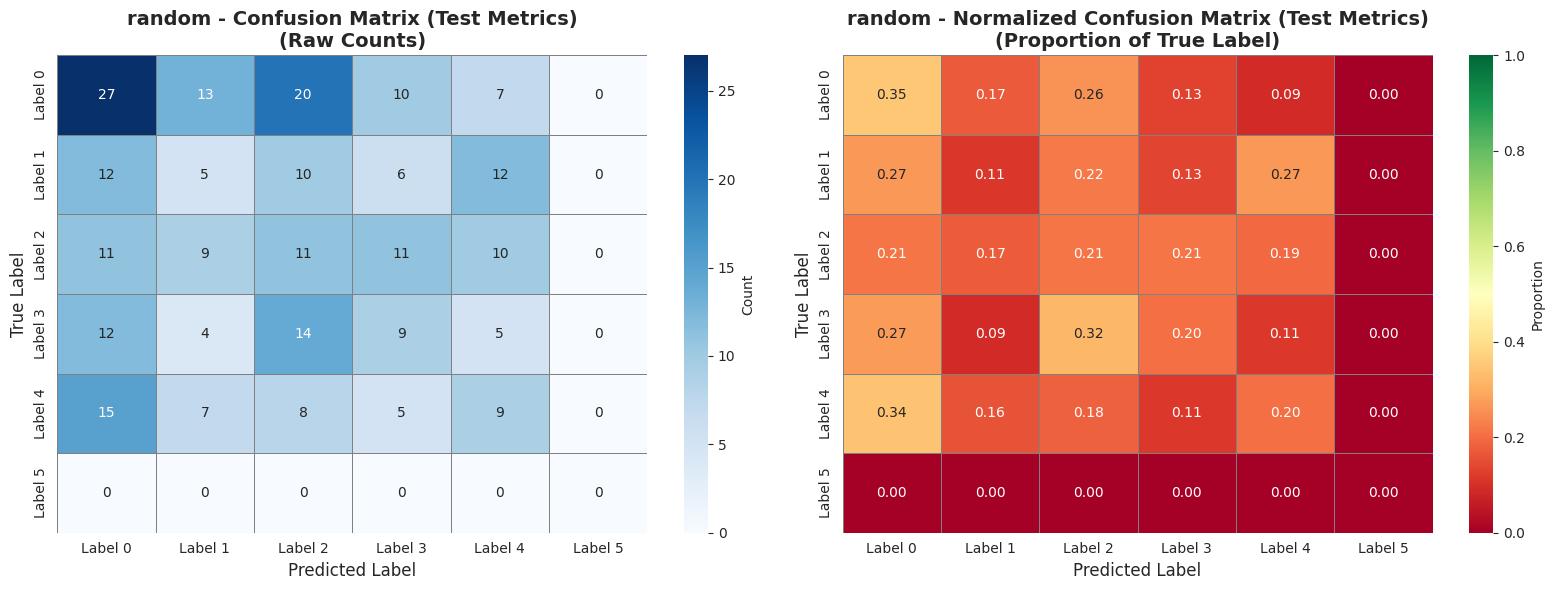


Confusion Matrix Statistics:
  Total predictions: 262
  Correct predictions (diagonal): 61
  Incorrect predictions (off-diagonal): 201
  Accuracy: 0.2328

Per-label statistics:
  Label 0: 27/77 correct (35.06%)
  Label 1: 5/45 correct (11.11%)
  Label 2: 11/52 correct (21.15%)
  Label 3: 9/44 correct (20.45%)
  Label 4: 9/44 correct (20.45%)
  Label 5: No samples


In [7]:
def plot_confusion_matrix(metrics_dict, dataset="test_metrics"):
    """
    Plot confusion matrix showing hits (diagonal) and misses (off-diagonal).

    Args:
        metrics_dict: Dictionary containing model metrics
        dataset: Which dataset to use ('train_metrics', 'cv_metrics', or 'test_metrics')
    """
    if metrics_dict[dataset] is None:
        print(f"Warning: {dataset} not available for this model")
        return

    data = metrics_dict[dataset]

    cm = np.array(data["confusion_matrix"])
    # Pad to 6x6 if needed (for label 5)
    if cm.shape[0] < 6:
        padded_cm = np.zeros((6, 6), dtype=int)
        padded_cm[: cm.shape[0], : cm.shape[1]] = cm
        cm = padded_cm

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax1,
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Count"},
    )
    ax1.set_title(
        f"{metrics_dict['model']} - Confusion Matrix ({dataset.replace('_', ' ').title()})\n(Raw Counts)",
        fontsize=14,
        fontweight="bold",
    )
    ax1.set_xlabel("Predicted Label", fontsize=12)
    ax1.set_ylabel("True Label", fontsize=12)
    ax1.set_xticklabels([f"Label {i}" for i in range(6)])
    ax1.set_yticklabels([f"Label {i}" for i in range(6)])

    # Plot 2: Normalized confusion matrix (by true label)
    cm_normalized = cm.astype("float")
    row_sums = cm.sum(axis=1, keepdims=True)
    # Avoid division by zero
    row_sums[row_sums == 0] = 1
    cm_normalized = cm_normalized / row_sums

    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="RdYlGn",
        ax=ax2,
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Proportion"},
        vmin=0,
        vmax=1,
    )
    ax2.set_title(
        f"{metrics_dict['model']} - Normalized Confusion Matrix ({dataset.replace('_', ' ').title()})\n(Proportion of True Label)",
        fontsize=14,
        fontweight="bold",
    )
    ax2.set_xlabel("Predicted Label", fontsize=12)
    ax2.set_ylabel("True Label", fontsize=12)
    ax2.set_xticklabels([f"Label {i}" for i in range(6)])
    ax2.set_yticklabels([f"Label {i}" for i in range(6)])

    plt.tight_layout()
    plt.show()

    total = cm.sum()
    correct = np.trace(cm)
    accuracy = correct / total if total > 0 else 0

    print("\nConfusion Matrix Statistics:")
    print(f"  Total predictions: {total}")
    print(f"  Correct predictions (diagonal): {correct}")
    print(f"  Incorrect predictions (off-diagonal): {total - correct}")
    print(f"  Accuracy: {accuracy:.4f}")
    print("\nPer-label statistics:")
    for i in range(6):
        true_count = cm[i, :].sum()
        correct_count = cm[i, i]
        if true_count > 0:
            per_label_acc = correct_count / true_count
            print(
                f"  Label {i}: {correct_count}/{true_count} correct ({per_label_acc:.2%})"
            )
        else:
            print(f"  Label {i}: No samples")


print("=" * 80)
print("TRAIN SET CONFUSION MATRIX")
print("=" * 80)
plot_confusion_matrix(metrics_data, "train_metrics")

print("\n" + "=" * 80)
print("CROSS-VALIDATION CONFUSION MATRIX")
print("=" * 80)
plot_confusion_matrix(metrics_data, "cv_metrics")

print("\n" + "=" * 80)
print("TEST SET CONFUSION MATRIX")
print("=" * 80)
plot_confusion_matrix(metrics_data, "test_metrics")

## All models

Comparing all available models...



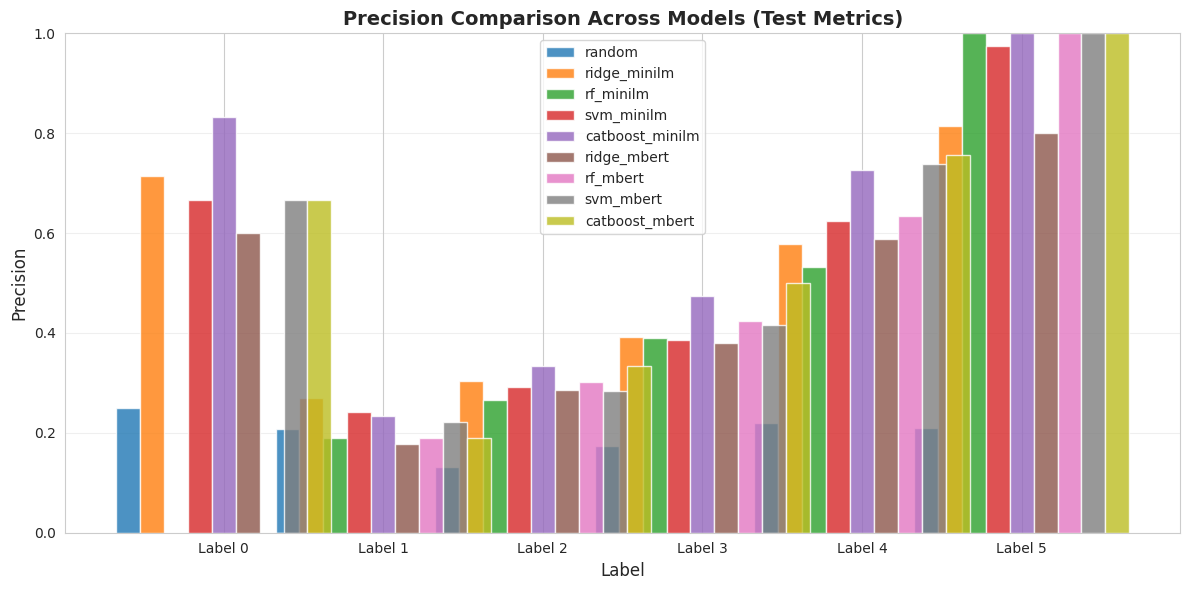

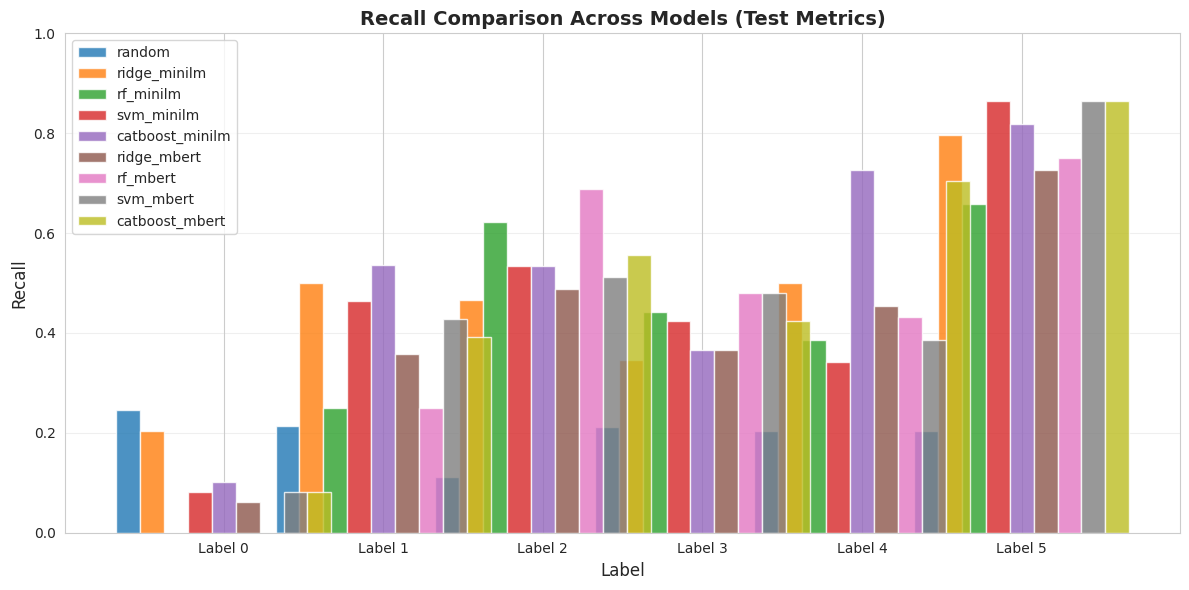

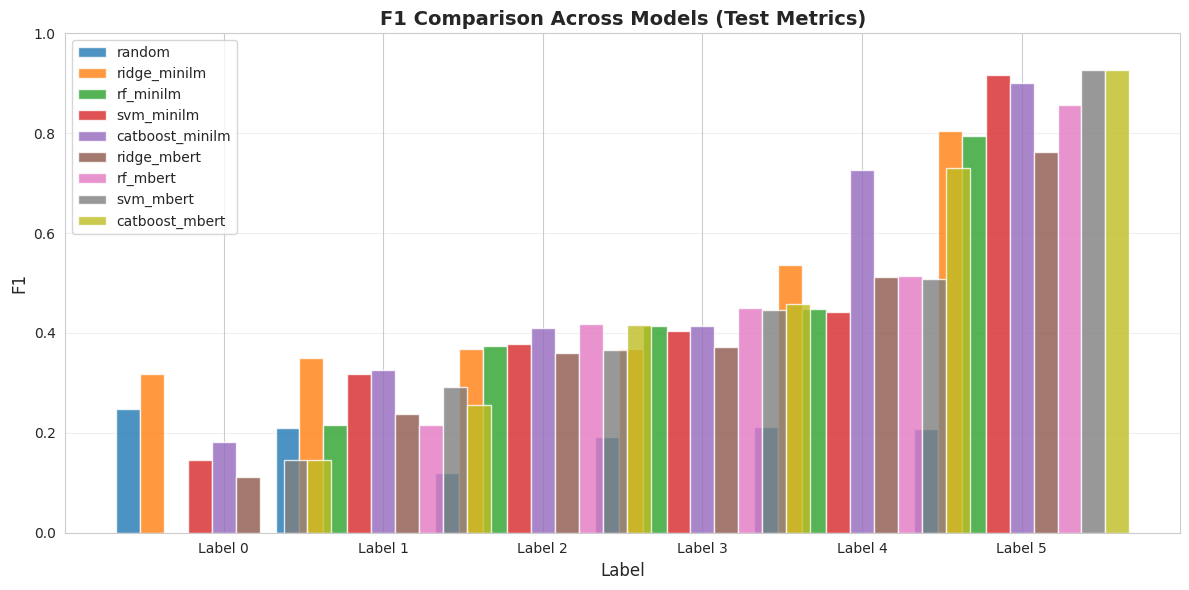

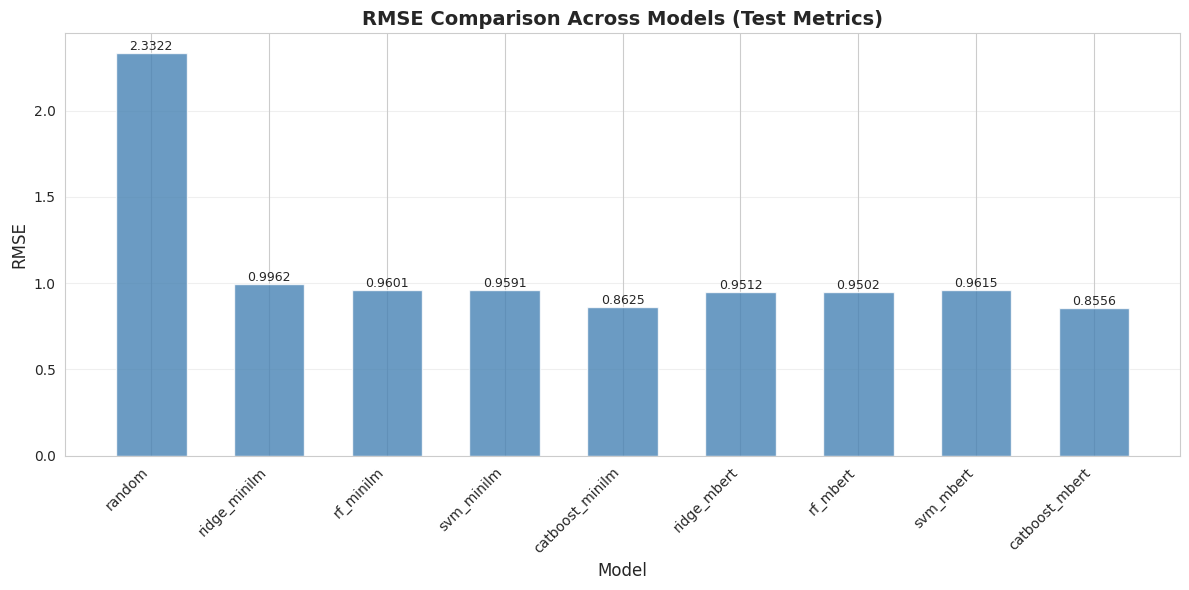

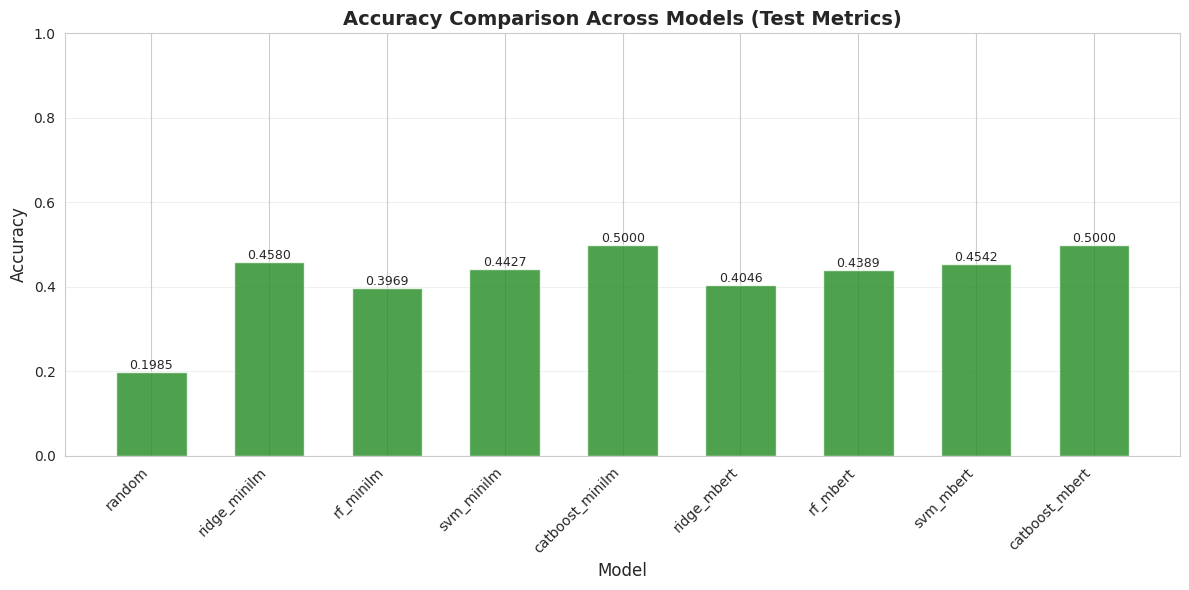

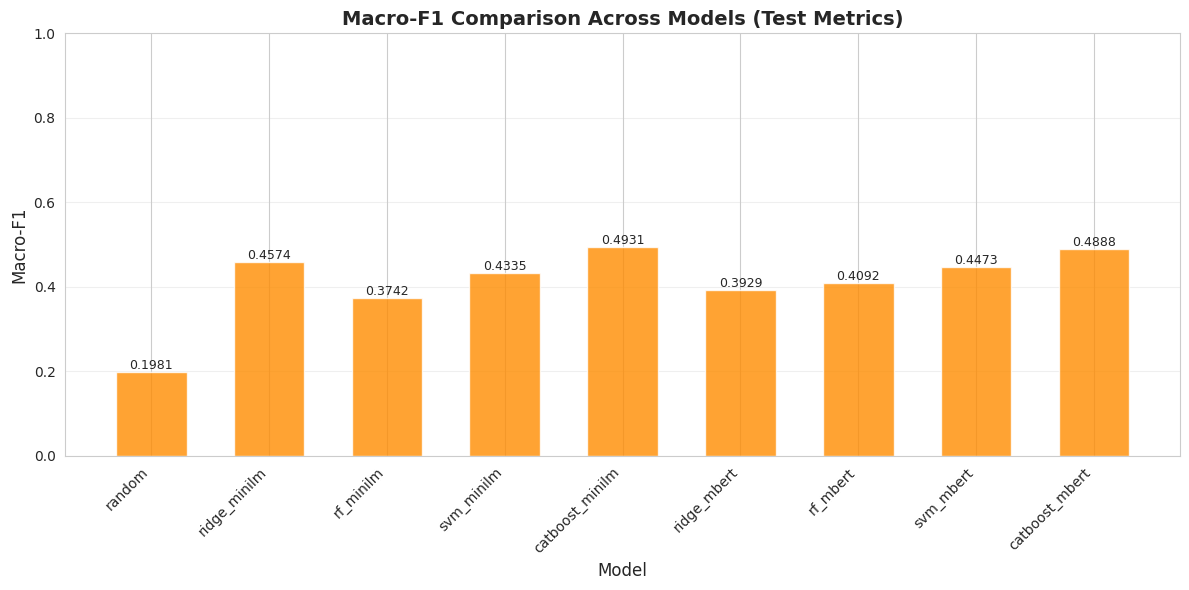

In [30]:
def compare_models(metrics_files, dataset="test_metrics"):
    """
    Compare metrics across multiple models.
    """
    models_data = []

    for file in metrics_files:
        with open(file, "r") as f:
            data = json.load(f)
            if data.get(dataset) is not None:
                models_data.append({"model": data["model"], "metrics": data[dataset]})

    if not models_data:
        print(f"No models with {dataset} available")
        return

    for metric_name in ["Precision", "Recall", "F1"]:
        fig, ax = plt.subplots(figsize=(12, 6))

        for i, model_data in enumerate(models_data):
            metric_key = metric_name.lower()
            values = model_data["metrics"][metric_key]
            # Pad to 6 labels
            values = values + [0.0] * (6 - len(values))

            x = np.arange(6) + i * 0.15
            ax.bar(x, values[:6], width=0.15, label=model_data["model"], alpha=0.8)

        ax.set_xlabel("Label", fontsize=12)
        ax.set_ylabel(metric_name, fontsize=12)
        ax.set_title(
            f"{metric_name} Comparison Across Models ({dataset.replace('_', ' ').title()})",
            fontsize=14,
            fontweight="bold",
        )
        ax.set_xticks(np.arange(6) + 0.15 * (len(models_data) - 1) / 2)
        ax.set_xticklabels([f"Label {i}" for i in range(6)])
        ax.legend(fontsize=10)
        ax.set_ylim(0, 1.0)
        ax.grid(axis="y", alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Plot RMSE comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    model_names = [model_data["model"] for model_data in models_data]
    rmse_values = [np.sqrt(model_data["metrics"]["mse"]) for model_data in models_data]

    x = np.arange(len(model_names))
    bars = ax.bar(x, rmse_values, width=0.6, alpha=0.8, color="steelblue")

    # Add value labels on top of bars
    for i, (bar, value) in enumerate(zip(bars, rmse_values)):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{value:.4f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("RMSE", fontsize=12)
    ax.set_title(
        f"RMSE Comparison Across Models ({dataset.replace('_', ' ').title()})",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Plot Accuracy comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    accuracy_values = [model_data["metrics"]["accuracy"] for model_data in models_data]

    x = np.arange(len(model_names))
    bars = ax.bar(x, accuracy_values, width=0.6, alpha=0.8, color="forestgreen")

    # Add value labels on top of bars
    for i, (bar, value) in enumerate(zip(bars, accuracy_values)):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{value:.4f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_title(
        f"Accuracy Comparison Across Models ({dataset.replace('_', ' ').title()})",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    ax.set_ylim(0, 1.0)
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Plot Macro-F1 comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    # Compute macro-F1 as the mean of per-label F1 scores
    macro_f1_values = [
        np.mean(model_data["metrics"]["f1"]) for model_data in models_data
    ]

    x = np.arange(len(model_names))
    bars = ax.bar(x, macro_f1_values, width=0.6, alpha=0.8, color="darkorange")

    # Add value labels on top of bars
    for i, (bar, value) in enumerate(zip(bars, macro_f1_values)):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{value:.4f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("Macro-F1", fontsize=12)
    ax.set_title(
        f"Macro-F1 Comparison Across Models ({dataset.replace('_', ' ').title()})",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    ax.set_ylim(0, 1.0)
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


if len(metrics_files) > 0:
    print("Comparing all available models...\n")
    compare_models(metrics_files, "test_metrics")

In [31]:
all_metrics = []
for file in metrics_files:
    with open(file, "r") as f:
        data = json.load(f)
        all_metrics.append(
            {
                "Model": data["model"],
                "Train RMSE": np.sqrt(data.get("train_metrics", {}).get("mse", np.nan))
                if data.get("train_metrics", {}).get("mse") is not None
                else np.nan,
                "CV RMSE": np.sqrt(data.get("cv_metrics", {}).get("mse", np.nan))
                if data.get("cv_metrics", {}).get("mse") is not None
                else np.nan,
                "Test RMSE": np.sqrt(data.get("test_metrics", {}).get("mse", np.nan))
                if data.get("test_metrics", {}).get("mse") is not None
                else np.nan,
                "Train Acc": data.get("train_metrics", {}).get("accuracy", None),
                "CV Acc": data.get("cv_metrics", {}).get("accuracy", None),
                "Test Acc": data.get("test_metrics", {}).get("accuracy", None),
                "Train Macro-F1": np.mean(data.get("train_metrics", {}).get("f1", []))
                if data.get("train_metrics", {}).get("f1")
                else None,
                "CV Macro-F1": np.mean(data.get("cv_metrics", {}).get("f1", []))
                if data.get("cv_metrics", {}).get("f1")
                else None,
                "Test Macro-F1": np.mean(data.get("test_metrics", {}).get("f1", []))
                if data.get("test_metrics", {}).get("f1")
                else None,
            }
        )

metrics_df = pd.DataFrame(all_metrics)

display(
    metrics_df.style.format(
        {
            "Train RMSE": "{:.4f}",
            "CV RMSE": "{:.4f}",
            "Test RMSE": "{:.4f}",
            "Train Acc": "{:.4f}",
            "CV Acc": "{:.4f}",
            "Test Acc": "{:.4f}",
            "Train Macro-F1": "{:.4f}",
            "CV Macro-F1": "{:.4f}",
            "Test Macro-F1": "{:.4f}",
        }
    ).set_caption("Model Metrics Comparison")
)

,Model,Train RMSE,CV RMSE,Test RMSE,Train Acc,CV Acc,Test Acc,Train Macro-F1,CV Macro-F1,Test Macro-F1
0,random,2.3129,2.3171,2.3322,0.1760,0.1455,0.1985,0.1762,0.1408,0.1981
1,ridge_minilm,0.0003,1.0752,0.9962,1.0000,0.3927,0.4580,1.0000,0.3924,0.4574
2,rf_minilm,0.1424,1.0039,0.9601,0.9974,0.3954,0.3969,0.9969,0.3603,0.3742
3,svm_minilm,0.2477,0.9346,0.9591,0.9260,0.3647,0.4427,0.9223,0.3627,0.4335
4,catboost_minilm,0.1720,0.8851,0.8625,0.9974,0.4513,0.5000,0.9977,0.4462,0.4931
5,ridge_mbert,0.5226,0.9526,0.9512,0.6607,0.4029,0.4046,0.6502,0.3915,0.3929
6,rf_mbert,0.0320,0.9813,0.9502,1.0000,0.4184,0.4389,1.0000,0.3851,0.4092
7,svm_mbert,0.2246,0.9375,0.9615,0.9413,0.3571,0.4542,0.9383,0.3537,0.4473
8,catboost_mbert,0.1554,0.8605,0.8556,1.0000,0.4694,0.5000,1.0000,0.4697,0.4888


## Training Curves Visualization

This section visualizes training and validation loss curves for fine-tuning trials.

In [7]:
from models.encoder.common import TRAINING_HISTORY_DIR
import matplotlib.cm as cm


def plot_all_folds_for_multiple_cv(cv_data_list):
    """
    Plot training curves for all folds across multiple CV runs in a grid.
    Each CV run will be shown with a different shade of blue (train) and red (val).

    Args:
        cv_data_list: List of dictionaries, each containing CV training history with structure:
                      {'model': str, 'n_splits': int, 'folds': [fold_data, ...], 'filename': str}
                      where each fold_data has 'train_losses' and 'val_losses' per epoch
    """
    if not cv_data_list:
        print("No CV data provided")
        return

    # Determine the maximum number of folds across all CV runs
    max_folds = max(len(cv_data["folds"]) for cv_data in cv_data_list)

    if max_folds == 0:
        print("No folds found in any CV data")
        return

    # Create subplot grid
    n_cols = min(3, max_folds)
    n_rows = (max_folds + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    if max_folds == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes

    # Generate color palettes for train and val losses
    n_cv_runs = len(cv_data_list)

    # Create blue shades for training and red shades for validation
    train_colors = cm.Blues(np.linspace(0.4, 0.9, n_cv_runs))
    val_colors = cm.Reds(np.linspace(0.4, 0.9, n_cv_runs))

    # Plot each fold across all CV runs
    for fold_idx in range(max_folds):
        ax = axes[fold_idx] if max_folds > 1 else axes[0]

        for cv_idx, cv_data in enumerate(cv_data_list):
            folds = cv_data["folds"]

            # Skip if this CV run doesn't have this fold
            if fold_idx >= len(folds):
                continue

            fold_data = folds[fold_idx]
            label_suffix = cv_data.get("filename", f"CV {cv_idx}")

            train_losses = fold_data["train_losses"]
            val_losses = fold_data["val_losses"]

            epochs_train = list(range(1, len(train_losses) + 1))
            epochs_val = list(range(1, len(val_losses) + 1))

            if train_losses:
                ax.plot(
                    epochs_train,
                    train_losses,
                    "-o",
                    color=train_colors[cv_idx],
                    alpha=0.7,
                    linewidth=2,
                    markersize=3,
                    label=f"Train - {label_suffix}",
                )
            if val_losses:
                ax.plot(
                    epochs_val,
                    val_losses,
                    "-o",
                    color=val_colors[cv_idx],
                    linewidth=2,
                    markersize=3,
                    label=f"Val - {label_suffix}",
                )

            # Mark best epoch if available
            if "best_epoch" in fold_data:
                best_epoch = fold_data["best_epoch"]
                best_val_loss = fold_data.get("best_val_loss", None)
                if best_val_loss is not None:
                    ax.axvline(
                        x=best_epoch,
                        color=val_colors[cv_idx],
                        linestyle="--",
                        alpha=0.3,
                        linewidth=1,
                    )
                    ax.plot(
                        best_epoch,
                        best_val_loss,
                        "*",
                        color=val_colors[cv_idx],
                        markersize=10,
                        zorder=5,
                    )

        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"Fold {fold_idx}", fontweight="bold")
        ax.legend(fontsize=8, loc="best")
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for idx in range(max_folds, len(axes)):
        axes[idx].axis("off")

    # Create title from all model names
    model_names = [cv_data.get("model", "Unknown") for cv_data in cv_data_list]
    if len(set(model_names)) == 1:
        title = f"{model_names[0]} - All Folds ({n_cv_runs} CV runs)"
    else:
        title = f"Cross-Validation Comparison - All Folds ({n_cv_runs} runs)"

    fig.suptitle(title, fontsize=16, fontweight="bold", y=1.00)
    plt.tight_layout()
    plt.show()

### Cross-validation

In [8]:
# Find CV training history files
cv_history_files = sorted(list(TRAINING_HISTORY_DIR.glob("*_cv_*.json")))
print(f"Found {len(cv_history_files)} CV training history files:")
for f in cv_history_files:
    print(f"  - {f.name}")

Found 7 CV training history files:
  - finetuned_mbert_cv_20251119_122957.json
  - finetuned_mbert_cv_20251119_124814.json
  - finetuned_mbert_cv_20251119_131747.json
  - finetuned_mbert_cv_20251119_133420.json
  - finetuned_mbert_cv_20251119_134459.json
  - finetuned_mbert_cv_20251119_135639.json
  - finetuned_mbert_cv_20251119_142512.json


Loading CV training history from: finetuned_mbert_cv_20251119_122957.json
  Model: finetuned_mbert, Folds: 5
Loading CV training history from: finetuned_mbert_cv_20251119_124814.json
  Model: finetuned_mbert, Folds: 5
Loading CV training history from: finetuned_mbert_cv_20251119_131747.json
  Model: finetuned_mbert, Folds: 5
Loading CV training history from: finetuned_mbert_cv_20251119_133420.json
  Model: finetuned_mbert, Folds: 5
Loading CV training history from: finetuned_mbert_cv_20251119_134459.json
  Model: finetuned_mbert, Folds: 5
Loading CV training history from: finetuned_mbert_cv_20251119_135639.json
  Model: finetuned_mbert, Folds: 5
Loading CV training history from: finetuned_mbert_cv_20251119_142512.json
  Model: finetuned_mbert, Folds: 5

Plotting 7 CV run(s)...



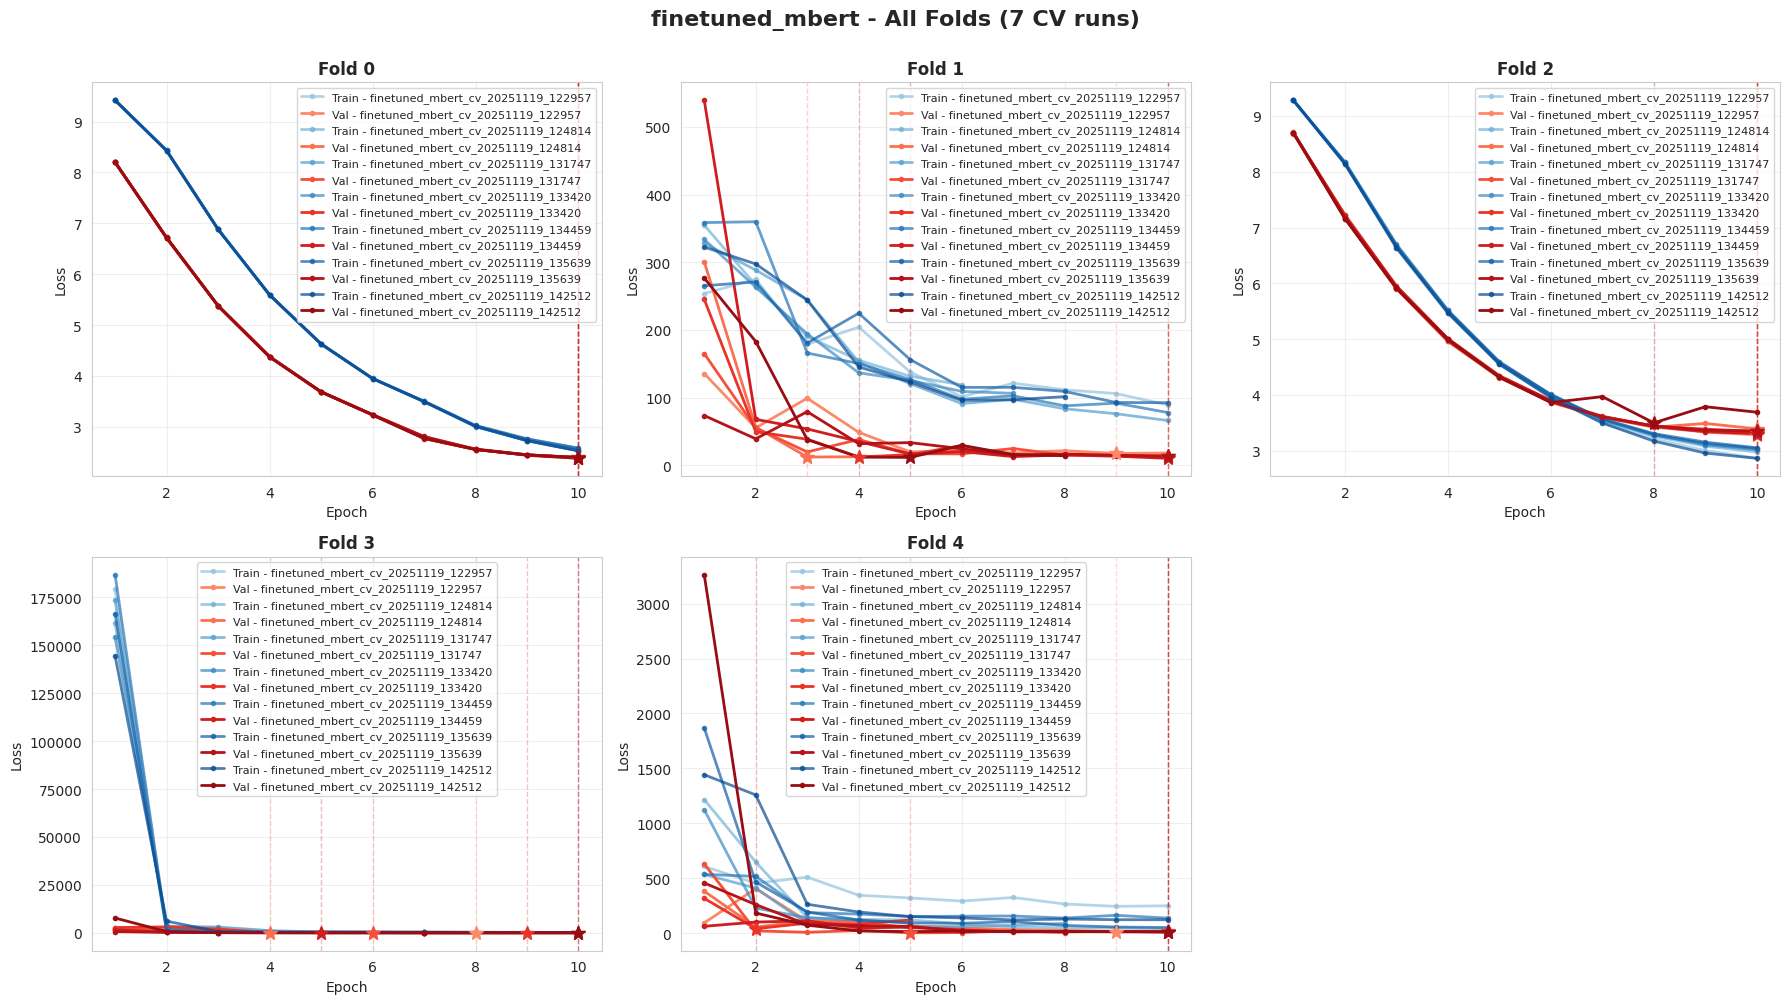

In [9]:
# Select which CV files to visualize (can select multiple)
if cv_history_files:
    # Specify indices of files to compare (e.g., [0] for first file, [0, 1] for first two files)
    CV_FILE_INDICES = list(
        range(len(cv_history_files))
    )  # Modify this list to select multiple files

    cv_data_list = []

    for idx in CV_FILE_INDICES:
        if idx < len(cv_history_files):
            selected_file = cv_history_files[idx]

            print(f"Loading CV training history from: {selected_file.name}")

            with open(selected_file, "r") as f:
                cv_data = json.load(f)

            # Add filename for labeling
            cv_data["filename"] = selected_file.stem
            cv_data_list.append(cv_data)

            print(f"  Model: {cv_data['model']}, Folds: {cv_data['n_splits']}")

    print(f"\nPlotting {len(cv_data_list)} CV run(s)...\n")
    plot_all_folds_for_multiple_cv(cv_data_list)
else:
    print("No CV training history files found!")

### Single training runs (no CV)

In [10]:
# Find single training run history files (non-CV)
train_history_files = sorted(list(TRAINING_HISTORY_DIR.glob("*_train_*.json")))
print(f"Found {len(train_history_files)} training history files:")
for f in train_history_files:
    print(f"  - {f.name}")

Found 18 training history files:
  - finetuned_mbert_train_20251119_100119.json
  - finetuned_mbert_train_20251119_100547.json
  - finetuned_mbert_train_20251119_110627.json
  - finetuned_mbert_train_20251119_111007.json
  - finetuned_mbert_train_20251119_111427.json
  - finetuned_mbert_train_20251119_111743.json
  - finetuned_mbert_train_20251119_112104.json
  - finetuned_mbert_train_20251119_112433.json
  - finetuned_mbert_train_20251119_112815.json
  - finetuned_mbert_train_20251119_114956.json
  - finetuned_mbert_train_20251119_115321.json
  - finetuned_mbert_train_20251119_115641.json
  - finetuned_mbert_train_20251119_115929.json
  - finetuned_mbert_train_20251119_120835.json
  - finetuned_mbert_train_20251119_121330.json
  - finetuned_mbert_train_20251119_121555.json
  - finetuned_mbert_train_20251119_121831.json
  - finetuned_mbert_train_20251119_122123.json


Loading training history from: finetuned_mbert_train_20251119_100119.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_100547.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_110627.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_111007.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_111427.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_111743.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_112104.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_112433.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_112815.json
  Model: finetuned_mbert, Epochs: 10
L

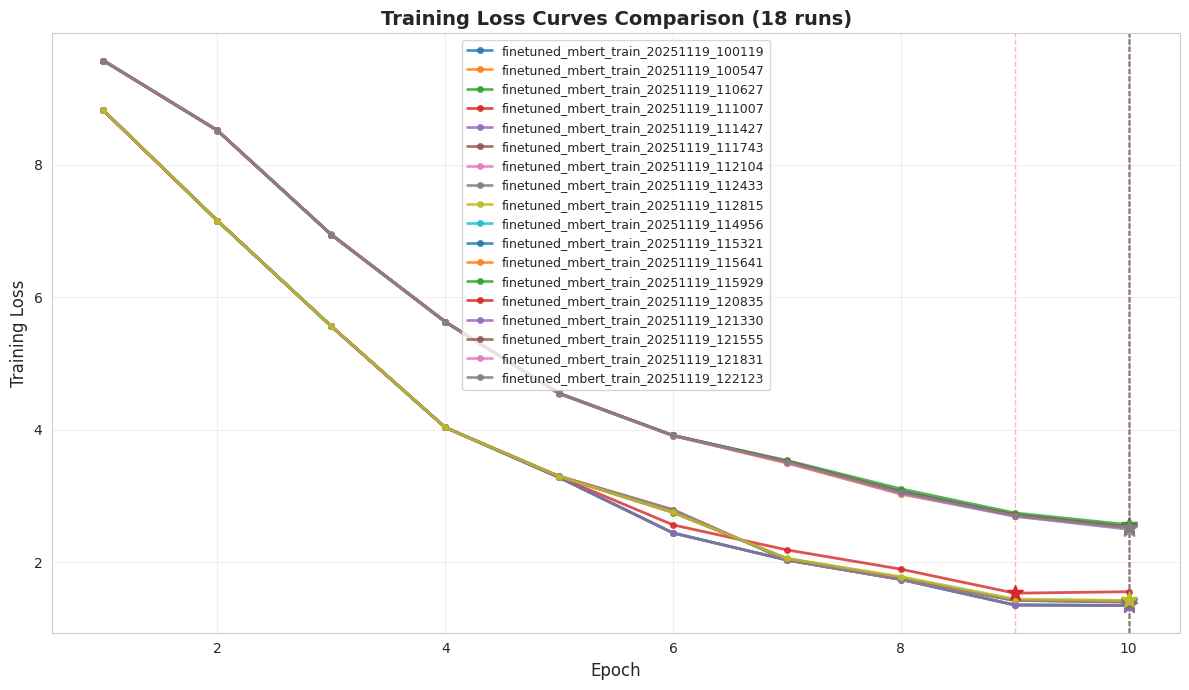


Plotted 18 training run(s)


In [11]:
# Select which training files to visualize and plot them together
if train_history_files:
    # Specify indices of files to compare (e.g., [0] for first file, [0, 1] for first two files)
    TRAIN_FILE_INDICES = list(
        range(len(train_history_files))
    )  # Modify this list to select multiple files

    fig, ax = plt.subplots(figsize=(12, 7))

    # Generate color palette
    n_files = len(TRAIN_FILE_INDICES)
    colors = cm.tab10(np.linspace(0, 1, min(n_files, 10)))

    for idx, file_idx in enumerate(TRAIN_FILE_INDICES):
        if file_idx < len(train_history_files):
            selected_file = train_history_files[file_idx]

            print(f"Loading training history from: {selected_file.name}")

            with open(selected_file, "r") as f:
                train_data = json.load(f)

            model_name = train_data.get("model", "Unknown")
            train_losses = train_data.get("train_losses", [])

            if train_losses:
                epochs = list(range(1, len(train_losses) + 1))
                color = colors[idx % len(colors)]

                ax.plot(
                    epochs,
                    train_losses,
                    "-o",
                    color=color,
                    linewidth=2,
                    markersize=4,
                    label=f"{selected_file.stem}",
                    alpha=0.8,
                )

                # Mark best epoch if available
                if "best_epoch" in train_data:
                    best_epoch = train_data["best_epoch"]
                    best_loss = train_data.get("best_train_loss")
                    if best_loss is not None:
                        ax.axvline(
                            x=best_epoch,
                            color=color,
                            linestyle="--",
                            alpha=0.3,
                            linewidth=1,
                        )
                        ax.plot(
                            best_epoch,
                            best_loss,
                            "*",
                            color=color,
                            markersize=12,
                            zorder=5,
                        )

                print(f"  Model: {model_name}, Epochs: {len(train_losses)}")

    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Training Loss", fontsize=12)
    ax.set_title(
        f"Training Loss Curves Comparison ({n_files} runs)",
        fontsize=14,
        fontweight="bold",
    )
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nPlotted {len(TRAIN_FILE_INDICES)} training run(s)")
else:
    print("No training history files found!")